In [73]:
from jax import grad, jit, vmap
import jax.numpy as jnp
import tensorflow as tf
import torch
from torch import nn

import random
import os
from sklearn.datasets import make_moons
import numpy as np
import time
import matplotlib.pyplot as plt

Train a single hidden layer fully connected neural network for binary classification through JAX, TensorFlow and Pytorch to compare the performance.

The activation function of the hidden layer is tanh. The loss function used is the log loss/cross entropy, which is equivalent to the normalized negative log likelihood of the data.

The results on Google Colab default setting show that JAX is the fastest, followed by PyTorch (5 times lower than JAX), and TensorFlow is the slowest (10 times lower than PyTorch).

1. JAX

In [2]:
n_samples = 200
n_features = 2
n_hidden_nodes = 10
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=0)
X = np.c_[X, np.ones(y.size)]

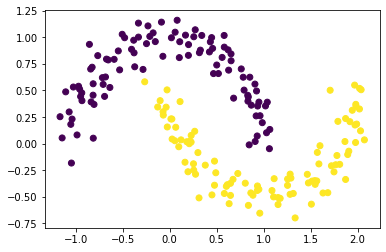

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [17]:
def sigmoid(x):
  return 1/(1 + jnp.exp(x))

def forward(w, X): 
  """
  Arguments:
    w (tuple of numpy.ndarray): 
      The tensor used to construct the neutral network. The first element is the 
      tensor to construct the hidden layer with shape [p, m], and the second 
      element is the tensor to construct the output layer with shape [m, 1].
    X (numpy.ndarray):
      The input data with shape [n, p]. Each row is one observation and each column
      is one feature.

  Returns:
    A one-dimension array containing the predicted probability for each observation.
  """
  # hidden layer
  X = jnp.tanh(jnp.dot(X, w[0]))
  # output layer
  preds = sigmoid(jnp.dot(X, w[1]))
  return preds

def loss(w, X, y):
  preds = forward(w, X)
  # log loss
  return -jnp.mean(jnp.multiply(y, jnp.log(preds)) + jnp.multiply(1 - y, jnp.log(1 - preds)))

def training_jax(loss, w, X, y, lr=0.01, n_iters=10000):
  losses = []
  loss = jit(loss)
  loss_grad = jit(grad(loss))
  t0 = time.time()
  for i in range(n_iters):
    grads = loss_grad(w, X, y)
    w[0] = w[0] - lr * grads[0] 
    w[1] = w[1] - lr * grads[1]
    cur_loss = loss(w, X, y)
    if i % 100 == 0:
      losses.append(cur_loss)
  t1 = time.time()
  return w, losses, t1 - t0

In [18]:
np.random.seed(0)
w = [np.random.randn(n_features+1, n_hidden_nodes), np.random.randn(n_hidden_nodes, 1)]
# w = [np.random.randn(n_features+1, n_hidden_nodes) * 0.01, np.random.randn(n_hidden_nodes, 1) * 0.01]

In [19]:
%%time
opt_w_jax, losses_jax, t_jax = training_jax(loss, w, X, y)

CPU times: user 2.21 s, sys: 8.46 ms, total: 2.22 s
Wall time: 2.22 s


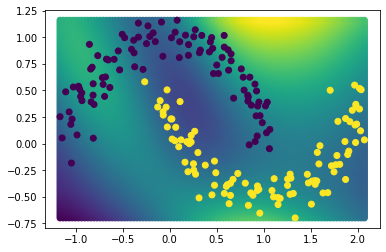

In [20]:
xs0, xs1 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
xs = np.c_[xs0.flatten(), xs1.flatten(), np.ones(xs0.shape[0] * xs0.shape[1])]
xs[:3]
plt.scatter(xs0, xs1, c=forward(opt_w_jax, xs))
plt.scatter(X[:, 0], X[:, 1], c=y)

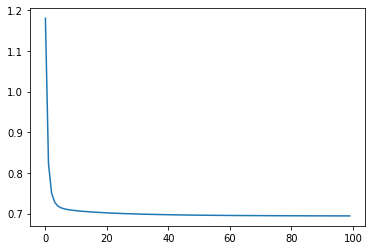

In [21]:
plt.plot(losses_jax)

2. TensorFlow

In [22]:
class TFMLP(tf.keras.Model):
  def __init__(self, n_features, n_hidden_nodes):
    super(TFMLP, self).__init__()
    self.w = [tf.random.uniform(shape=(n_features + 1, n_hidden_nodes), dtype=tf.float64), 
              tf.random.uniform(shape=(n_hidden_nodes, 1), dtype=tf.float64)]
  def forward(self, X):
        X = tf.tanh(tf.matmul(X, self.w[0]))
        preds = tf.sigmoid(tf.matmul(X, self.w[1]))

        return preds

In [25]:
def training_tf(model, X, y, lr=0.01, n_iters=10000):
  losses = []
  t0 = time.time()
  for i in range(n_iters):
    with tf.GradientTape(persistent=True) as g:
      g.watch(X)
      g.watch(model.w[0])
      g.watch(model.w[1])

      preds = model.forward(X)
      cur_loss = tf.reduce_mean(tf.losses.binary_crossentropy(y, preds), axis=0)

    dw1 = g.gradient(cur_loss, model.w[1])
    dw0 = g.gradient(cur_loss, model.w[0])
    model.w[0] = w[0] - lr * dw0
    model.w[1] = w[1] - lr * dw1
    if i % 100 == 0:
      losses.append(cur_loss)
  t1 = time.time()  
  return model.w, losses, t1 - t0

In [79]:
def set_seed_tf(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")


In [80]:
%%time
set_seed_tf(0)
opt_w_tf, losses_tf, t_tf = training_tf(TFMLP(n_features, n_hidden_nodes), tf.convert_to_tensor(X), tf.convert_to_tensor(y, dtype=tf.float64))

Random seed set as 0
CPU times: user 2min 6s, sys: 4.08 s, total: 2min 10s
Wall time: 2min 10s


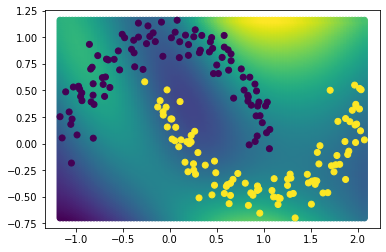

In [68]:
xs0, xs1 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
xs = np.c_[xs0.flatten(), xs1.flatten(), np.ones(xs0.shape[0] * xs0.shape[1])]
xs[:3]
plt.scatter(xs0, xs1, c=forward((opt_w_tf[0].numpy(), opt_w_tf[1].numpy()), xs))
plt.scatter(X[:, 0], X[:, 1], c=y)

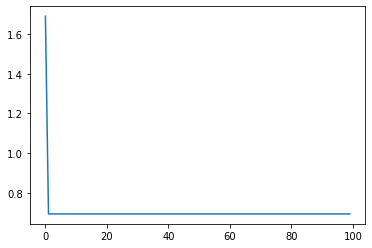

In [69]:
plt.plot(losses_tf)

3. PyTorch

In [33]:
class PTMLP(nn.Module):
  def __init__(self, n_features, n_hidden_nodes):
    super(PTMLP, self).__init__()
    self.w = [nn.Parameter(torch.randn(n_features + 1, n_hidden_nodes).double()), nn.Parameter(torch.randn(n_hidden_nodes, 1).double())]

  def forward(self, X):
    X = torch.tanh(torch.matmul(X, self.w[0]))
    preds = torch.sigmoid(torch.matmul(X, self.w[1]))
    return preds
  
  def loss(self, y, preds):
    return - torch.mean(y * torch.log(preds) + (1 - y) * torch.log(1 - preds))

In [34]:
def training_pt(model, X, y, lr=0.01, n_iters=10000):
  losses = []
  t0 = time.time()
  for i in range(n_iters):
    preds = model.forward(X)
    cur_loss = model.loss(y, preds)

    cur_loss.backward()
    with torch.no_grad():
      for params in model.w:
        params -= 1e-2 * params.grad

    # manual zero_grad
    for j in range(len(model.w)):
      model.w[j].grad *= 0.0 

    if i % 100 == 0:
      losses.append(cur_loss)
  t1 = time.time()

  return model.w, losses, t1 - t0

In [75]:
def set_seed_pt(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [76]:
%%time
set_seed_pt(0)
opt_w_pt, losses_pt, t_pt = training_pt(PTMLP(n_features, n_hidden_nodes), torch.from_numpy(X), torch.from_numpy(y).double())

Random seed set as 0
CPU times: user 10.9 s, sys: 369 ms, total: 11.2 s
Wall time: 11.4 s


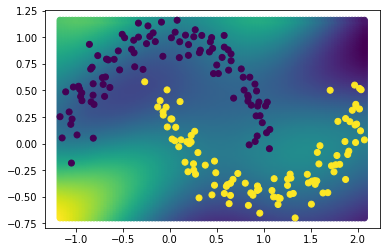

In [63]:
xs0, xs1 = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
xs = np.c_[xs0.flatten(), xs1.flatten(), np.ones(xs0.shape[0] * xs0.shape[1])]
xs[:3]
plt.scatter(xs0, xs1, c=forward((opt_w_pt[0].detach().numpy(), opt_w_pt[1].detach().numpy()), xs))
plt.scatter(X[:, 0], X[:, 1], c=y)

In [64]:
losses_pt = [l.detach().numpy() for l in losses_pt]

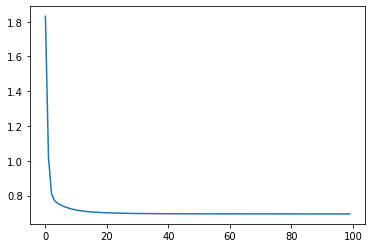

In [65]:
plt.plot(losses_pt)

In [81]:
print(f"JAX        10000 iteration use {f'{t_jax:05.4f} s':>10}, final loss is {losses_jax[-1]:0.6f}")
print(f"TensorFlow 10000 iteration use {f'{t_tf:05.4f} s':>10}, final loss is {losses_tf[-1]:0.6f}")
print(f"PyTorch    10000 iteration use {f'{t_pt:05.4f} s':>10}, final loss is {losses_pt[-1]:0.6f}")

JAX        10000 iteration use   2.2173 s, final loss is 0.694080
TensorFlow 10000 iteration use 130.7170 s, final loss is 0.694066
PyTorch    10000 iteration use  11.3528 s, final loss is 0.693282
